# figure demonstrating the principles of event-based cameras

inspiration from https://lenzgregor.com/posts/event-cameras/



In [25]:
bias = .3
N_threshold = 25
N_frame = 30
smoothing = 10.0
smoothing = 15.0

In [26]:
import os
import numpy as np
phi = np.sqrt(5)/2 + 1/2

import matplotlib
import matplotlib.pyplot as plt

import matplotlib
subplotpars = matplotlib.figure.SubplotParams(left=0.125, right=.95, bottom=0.25, top=.975, wspace=0.05, hspace=0.05,)

figpath = None
figpath = '.'

dpi = 300
ext = 'svg'

def printfig(fig, name, ext=ext, figpath=figpath, dpi=None, bbox='tight'):
    fig.savefig(os.path.join(figpath, name + '.' + ext), dpi = dpi, bbox_inches=bbox, transparent=True)

if not(figpath is None): os.makedirs(figpath, exist_ok=True)

# define signal

Get a raw signal, time-filter it

In [27]:
fname = '/Users/laurentperrinet/Documents/GitHub/MotionClouds/docs/files/montypython.npy'
fname = '/Users/laurentperrinet/quantic/science/Hugo/OrientationPrecision/deep-bandwidth_old/datasets/montypython.npy'
%ls {fname}


/Users/laurentperrinet/quantic/science/Hugo/OrientationPrecision/deep-bandwidth_old/datasets/montypython.npy


In [29]:
movie = np.load(fname)
movie.shape, movie.min(), movie.max()

((54, 54, 4096), -0.4090308019447976, 0.5066523744236774)

In [ ]:
i_x, i_y = 0, 0
i_t_start, i_t_end = 0, 5000
i_t_start, i_t_end = 1500, 2500
i_t_middle = (i_t_end - i_t_start) //2

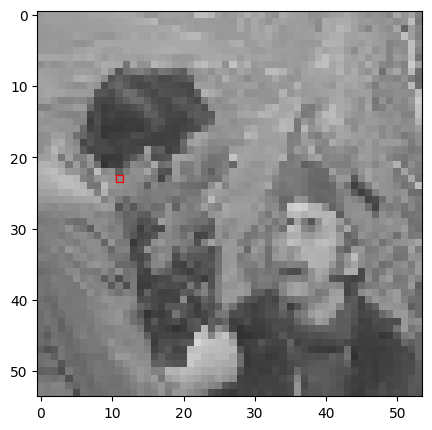

In [41]:
fig, ax = plt.subplots(figsize=(5, 5)) #, subplotpars=subplotpars)
ax.imshow(movie[:, ::-1, 0].T, vmin=-.5, vmax=.5, cmap=plt.cm.gray)
ax.plot([10.5, 11.5, 11.5, 10.5, 10.5], [22.5, 22.5, 23.5, 23.5, 22.5], 'r', lw=.9)

In [42]:
# 2/ transform light into image:
fnames = []
for i_frame in range(i_t_start, i_t_start+200): # i_t_end):
    fig, ax = plt.subplots(figsize=(5, 5)) #, subplotpars=subplotpars)
    ax.imshow(movie[:, ::-1, i_frame].T, vmin=-.5, vmax=.5, cmap=plt.cm.gray)
    ax.plot([10.5, 11.5, 11.5, 10.5, 10.5], [22.5, 22.5, 23.5, 23.5, 22.5], 'r', lw=.9)
    ax.set_xticks([])
    ax.set_yticks([])
    fname = f'/tmp/toto_frame_{i_frame:04d}.png'
    fig.savefig(fname, dpi=40, bbox_inches='tight')
    fnames.append(fname)
    plt.close('all')

def make_gif(gifname, fnames, fps, do_delete=True):
    import imageio

    with imageio.get_writer(gifname, mode='I', fps=fps) as writer:
        for fname in fnames:
            writer.append_data(imageio.imread(fname))

    from pygifsicle import optimize
    optimize(str(gifname))
    if do_delete: 
        for fname in fnames: os.remove(fname)
    return gifname
make_gif('movie.gif', fnames, fps=10)

/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_52305/29118117.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(fname))
gifsicle: warning: trivial adaptive palette (only 221 colors in source)


'movie.gif'

In [5]:
movie = np.exp(movie)


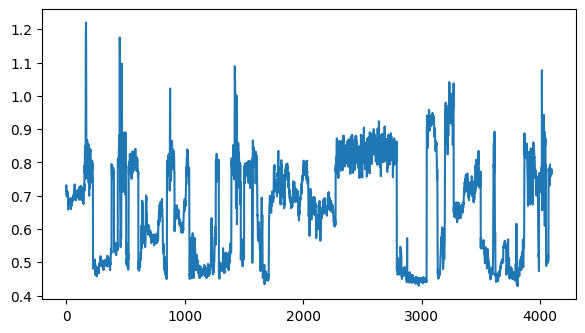

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(phi*4, 4), subplotpars=subplotpars)
ax.plot(movie[i_x, i_y, :] - bias)


In [7]:
movie_line = movie[i_x, i_y, i_t_start:i_t_end] - bias

(1000,)

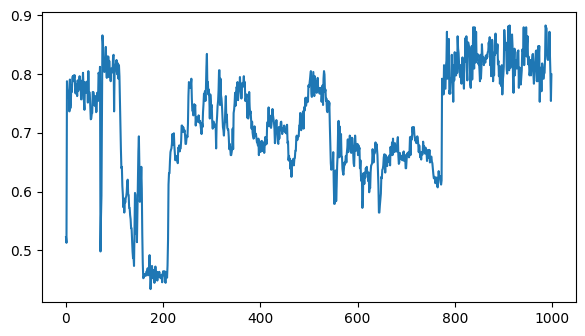

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(phi*4, 4), subplotpars=subplotpars)
ax.plot(movie_line)
movie_line.shape

In [9]:
# from scipy.signal import spline_filter
from scipy.signal import cspline1d, cspline1d_eval
time = np.linspace(0, i_t_end - i_t_start, 500)
movie_line = cspline1d_eval(cspline1d(movie_line, smoothing), time)
movie_line.shape, time.shape

((500,), (500,))

In [10]:
movie_line = cspline1d_eval(cspline1d(movie[i_x, i_y, :] - bias, smoothing), np.linspace(0, i_t_end - i_t_start, 500))
movie_line.shape, time.shape

((500,), (500,))

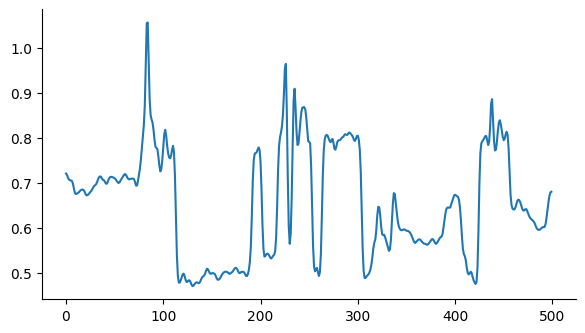

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(phi*4, 4), subplotpars=subplotpars)
ax.plot(movie_line)

# ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
# ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')

In [12]:
ymax = np.max(movie_line)
np.linspace(0, ymax, N_threshold, endpoint=True).shape, N_threshold

((25,), 25)

In [13]:

i_movie_quant = (movie_line / ymax * N_threshold).astype(int)
i_movie_quant


array([17, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 16, 16, 16, 16, 16,
       16, 16, 16, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 18, 18, 19, 20, 22, 24, 25,
       22, 20, 20, 19, 19, 19, 18, 18, 18, 18, 17, 17, 17, 17, 17, 18, 19,
       19, 19, 18, 18, 17, 17, 17, 18, 18, 18, 16, 14, 12, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 12, 13, 14, 16, 17, 18, 18, 18, 18, 18, 18, 17, 16, 14, 13,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 15, 17, 18, 18,
       19, 19, 20, 21, 22

In [14]:
range(10, 14), range(14, 10), np.arange(14, 10) 

(range(10, 14), range(14, 10), array([], dtype=int64))

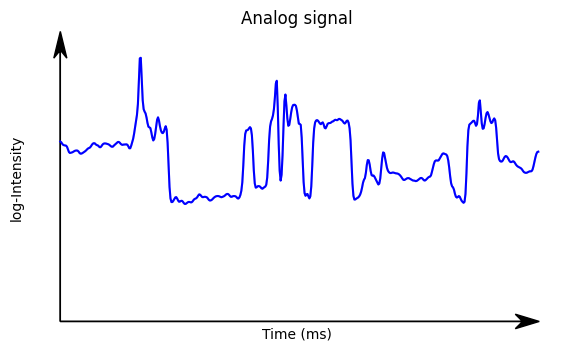

In [15]:
def do_plot(movie_line, N_frame=0, N_threshold=0,
            show_events=True,
            N_event=-1,
            ylabel='log-Intensity',
            xlabel='Time (ms)',
            title='Analog signal',
):
    tmax = len(movie_line)
    ymax = np.max(movie_line)*1.1

    fig, ax = plt.subplots(1, 1, figsize=(phi*4, 4), subplotpars=subplotpars)

    # compute events
    if N_threshold>0:

        events = []
        
        ysamples = np.linspace(0, ymax, N_threshold, endpoint=False)
        i_movie_quant = (movie_line / ymax * N_threshold).astype(int)

        for i_time in range(1, tmax):

            if not(i_movie_quant[i_time-1] == i_movie_quant[i_time]):
                pol = np.sign(i_movie_quant[i_time]-i_movie_quant[i_time-1])
                for i_movie in range(min(i_movie_quant[i_time-1], i_movie_quant[i_time]),
                                     max(i_movie_quant[i_time-1], i_movie_quant[i_time])):
                    events.append((i_time, pol, ysamples[i_movie+1]))
                
        if N_event == -1: 
            N_event = len(events)
            i_time_last = len(movie_line)
        else:
            i_time_last = events[N_event-1][0]
    else:
        i_time_last = len(movie_line)
                   
    # show the signal
    ax.plot(movie_line, alpha=.2, c='b')
    ax.plot(movie_line[:i_time_last], c='b')
    ax.set_ylim(0, ymax)
    # show the segment that crossed the threshold
    if N_threshold>0 and N_event < len(events):
        ax.plot([i_time_last-1, i_time_last], 
                [movie_line[i_time_last-1], movie_line[i_time_last]], 
                'b-', ms=4)
        # ax.plot([i_time_previous, i_time_last], 
        #         [movie_line[i_time_previous], movie_line[i_time_last]], 'b-', ms=4)
    # ax.spines['left'].set_position('center')
    ax.spines['right'].set_color('none')
    # ax.spines['bottom'].set_position('center')
    ax.spines['top'].set_color('none')

    # https://3diagramsperpage.wordpress.com/2014/05/25/arrowheads-for-axis-in-matplotlib/
    # removing the default axis on all sides:
    for side in ['bottom','right','top','left']:
        ax.spines[side].set_visible(False)
    
    # removing the axis ticks
    plt.xticks([]) # labels 
    plt.yticks([])
    ax.xaxis.set_ticks_position('none') # tick markers
    ax.yaxis.set_ticks_position('none')

    # matching arrowhead length and width

    # xmin, tmax = ax.get_xlim() 
    # ymin, ymax = ax.get_ylim()
    dps = fig.dpi_scale_trans.inverted()
    bbox = ax.get_window_extent().transformed(dps)
    width, height = bbox.width, bbox.height
    
    # manual arrowhead width and length
    hw = 1./20.*ymax
    hl = 1./20.*tmax
    lw = 1. # axis line width
    ohg = 0.3 # arrow overhang
    
    # compute matching arrowhead length and width
    # yhw = hw/(ymax-ymin)*(tmax-xmin)* height/width 
    # yhl = hl/(tmax-xmin)*(ymax-ymin)* width/height
    yhw = hw/ymax*tmax * height/width 
    yhl = hl/tmax*ymax * width/height
    
    # draw x and y axis
    ax.arrow(0, 0, tmax, 0., fc='k', ec='k', lw = lw, 
            head_width=hw, head_length=hl, overhang = ohg, 
            length_includes_head= True, clip_on = False) 
    
    ax.arrow(0, 0, 0., ymax, fc='k', ec='k', lw = lw, 
            head_width=yhw, head_length=yhl, overhang = ohg, 
            length_includes_head= True, clip_on = False) 
    ax.set_ylabel(ylabel)

    ax.set_xlabel(xlabel)
    ax.set_title(title)

    if N_frame>0:
        
        samples = np.linspace(0, int(tmax*.95), N_frame, dtype=int)
        for sample in samples:
            ax.plot([sample, sample], [0, ymax], 'k', ls='dotted', lw=.2)
            ax.plot([sample], [movie_line[sample]], 'o', color='orangered', fillstyle='none', lw=1)

 
    if N_threshold>0:
        
        # for ysample in ysamples[1:]:
        #     ax.plot([0, tmax], [ysample-threshold/2, ysample-threshold/2], 'k--', lw=.2)
        
        for ysample in ysamples:
            ax.plot([0, tmax], [ysample, ysample], 'k', lw=.2)

        # print(events[:(N_event)])
        for i_time, pol, movie_quant in events[:(N_event)]:
            ax.plot([i_time], [movie_quant], 
                     'r^' if pol == +1 else 'bv', alpha=.4)
            if show_events: ax.plot([i_time, i_time], [0, ymax/N_threshold], 'r' if pol == +1 else 'b', lw=1, alpha=.3)

    return fig, ax

fig, ax = do_plot(movie_line)


In [16]:
printfig(fig, 'analog_signal')

# do frames

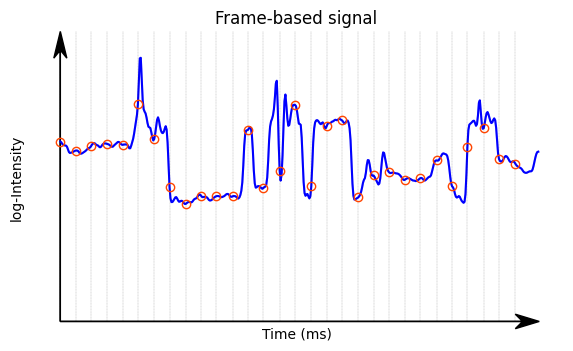

In [17]:
fig, ax = do_plot(movie_line, N_frame=N_frame, title='Frame-based signal')
printfig(fig, 'frame-based_signal')

# do events

In [18]:
# for N_event in [1, 5, 10, 50]:
#     fig, ax = do_plot(movie_line[:1000]-.425, N_threshold=N_threshold, N_event=N_event, show_events=False, title='Event-based signal')
#     plt.show()
#     printfig(fig, f'event-based_signal_raw_{N_event}')
N_threshold = 15

In [19]:

movie_line_short = movie_line[:200]-.370
movie_line.shape, movie_line_short.shape

((500,), (200,))

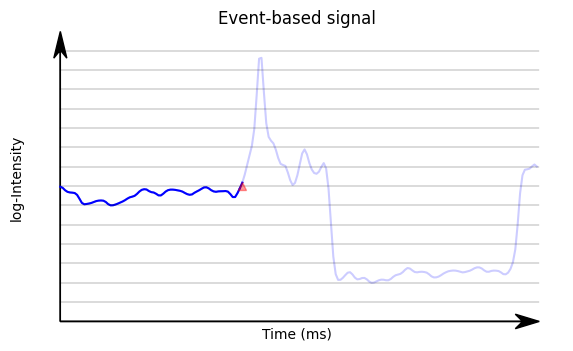

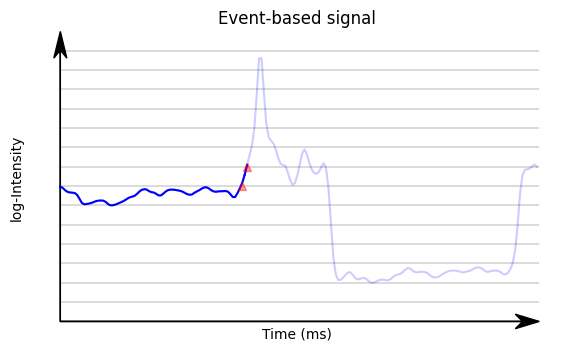

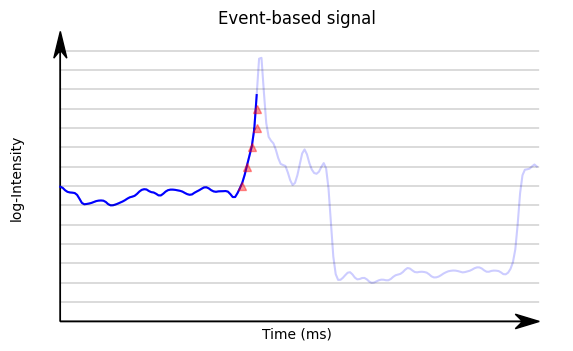

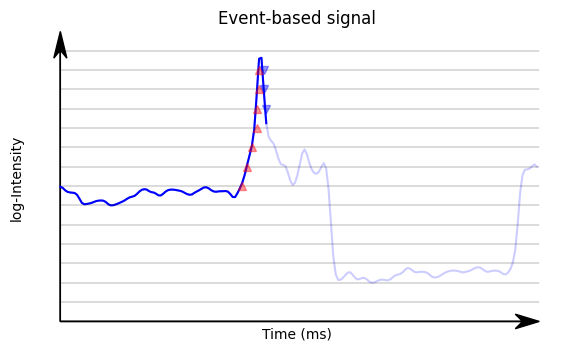

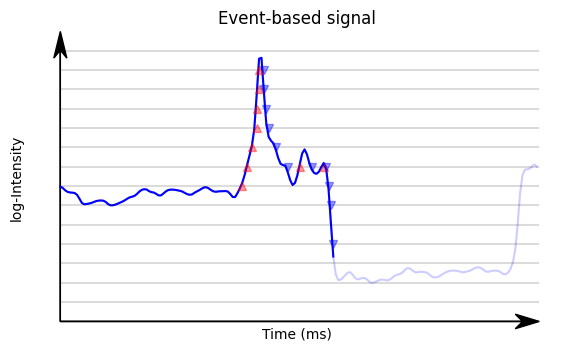

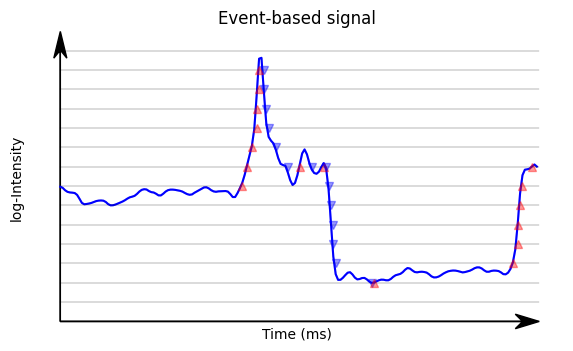

In [20]:
for N_event in [1, 2, 5, 10, 20, -1]:
    fig, ax = do_plot(movie_line_short, N_threshold=N_threshold, N_event=N_event, show_events=False, title='Event-based signal')
    plt.show()
    printfig(fig, f'event-based_signal_raw_{N_event}')

In [21]:
N_event


-1

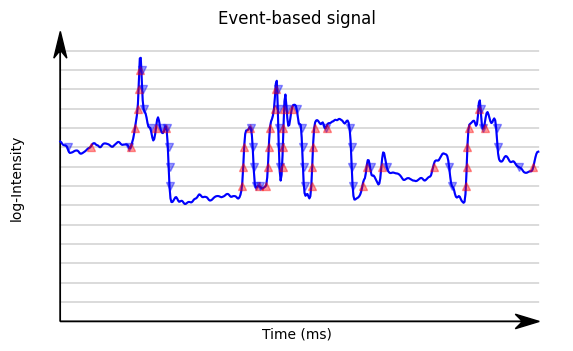

In [22]:
fig, ax = do_plot(movie_line, N_threshold=N_threshold, show_events=False, title='Event-based signal')
printfig(fig, 'event-based_signal_raw')

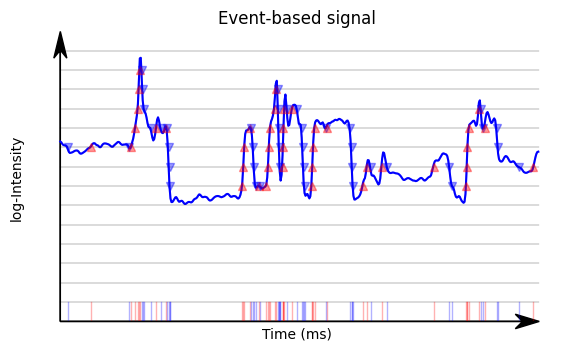

In [23]:
fig, ax = do_plot(movie_line, N_threshold=N_threshold, title='Event-based signal')
printfig(fig, 'event-based_signal')

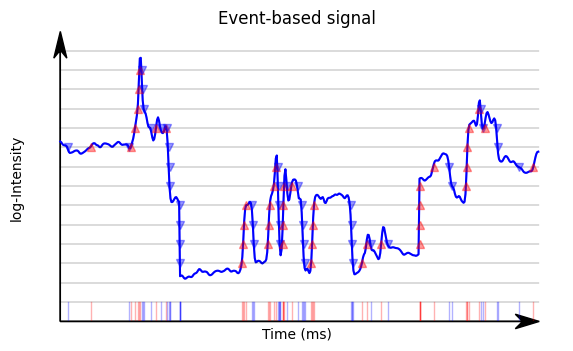

In [24]:
movie_line_low = movie_line.copy()
movie_line_low[len(movie_line)//4:3*len(movie_line)//4] -= 4.25 * (movie_line.max() / N_threshold)
fig, ax = do_plot(movie_line_low, N_threshold=N_threshold, title='Event-based signal')
printfig(fig, 'event-based_signal_low')